In [1]:
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'
import logging
logging.basicConfig(level=logging.INFO, format='')
import pandas as pd
import numpy as np
from bs4 import BeautifulSoup
import seaborn as sns
import rdkit
from sklearn.impute import SimpleImputer
from scipy.stats import kurtosis, skew
from rdkit import Chem, RDLogger
from rdkit.Chem import Draw
from rdkit.Chem import BondType
from rdkit.Chem.Draw import MolsToGridImage
from rdkit.Chem import PandasTools
from rdkit.Chem.Scaffolds import MurckoScaffold
from rdkit.ML.Descriptors import MoleculeDescriptors
import requests
import torch
import pubchempy as pcp
from tqdm import tqdm
import matplotlib.pyplot as plt
import matplotlib as mpl
from IPython.display import SVG, display
import sys
sys.path.append('C:\\Users\\PY\\jtvae2')
sys.path.append('../')
from fast_molvae.sample import load_model
model = load_model('../data/vocab.txt', '../fast_molvae/vae_model/model.epoch-19')
torch.cuda.is_available()
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import mean_absolute_error as mae
from sklearn.metrics import mean_absolute_percentage_error as mape
from sklearn.metrics import r2_score
from scipy.stats import spearmanr
import random
import joblib
%config InlineBackend.figure_format = 'retina'
%matplotlib inline
plt.rcParams['font.sans-serif'] = ["Arial"]
import warnings
warnings.filterwarnings('ignore')
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

Enabling RDKit 2020.09.1 jupyter extensions
C:\ProgramData\Anaconda3\envs\chemvae2\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
C:\ProgramData\Anaconda3\envs\chemvae2\lib\site-packages\torch\nn\_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


In [2]:
df_val=pd.read_csv('./model_valid.csv',encoding='gb18030')
df_val

,CAS,smiles,Initial PCE,Max_PCE,DOI
0,504-24-5,Nc1ccncc1,20.16,16.90,https://doi.org/10.1016/j.cej.2022.137033
1,60-35-5,CC(N)=O,20.88,22.70,https://doi.org/10.1016/j.cej.2022.138559
2,108-01-0,CN(C)CCO,19.70,20.69,https://doi.org/10.1002/solr.202101107
3,52-67-5,CC(C)(S)[C@@H](N)C(O)=O,22.44,24.09,https://doi.org/10.1002/solr.202200567
4,109-69-3,CCCCCl,20.56,21.35,https://doi.org/10.1002/solr.202100979
5,725-89-3,OC(=O)c1cc(cc(c1)C(F)(F)F)C(F)(F)F,18.45,21.09,https://doi.org/10.1021/acsami.1c18035
6,89-97-4,NCc1ccccc1Cl,20.70,22.60,https://doi.org/10.1021/acsami.2c02250
7,603-35-0,c1ccc(cc1)P(c2ccccc2)c3ccccc3,18.36,20.22,https://doi.org/10.1002/cssc.202102189
8,104-01-8,COc1ccc(CC(O)=O)cc1,20.97,22.32,https://doi.org/10.1016/j.jpowsour.2021.230734
9,540-63-6,SCCS,19.60,21.00,https://doi.org/10.1002/eom2.12185


In [5]:
df_pred_smi = df_val.iloc[:,1:2].values

tree_vecs=[]
mol_vecs=[]
for i in tqdm(np.arange(len(df_pred_smi)), desc="Encoding SMILES"):
    all_vec = []
    all_vec = model.encode_from_smiles(df_pred_smi[i])
    tree_vec, mol_vec = np.hsplit(all_vec, 2)
    tree_, _ = model.rsample(tree_vec, model.T_mean, model.T_var)
    mol_, _ = model.rsample(mol_vec, model.G_mean, model.G_var)
    tree_ = tree_.data.cpu().numpy()
    mol_ = mol_.data.cpu().numpy()
    tree_vecs.append(tree_)
    mol_vecs.append(mol_)
tree_vecs=np.array(tree_vecs).reshape(len(df_pred_smi),28)
mol_vecs=np.array(mol_vecs).reshape(len(df_pred_smi),28)
zpred_vec=np.hstack((tree_vecs,mol_vecs))
print(zpred_vec.shape)

molecule_smi= df_val.iloc[:,1]

descriptors = ['FractionCSP3', 'BCUT2D_MRLOW', 'fr_quatN', 'PEOE_VSA8', 'fr_Ar_N',
       'MinEStateIndex', 'fr_NH0', 'fr_imidazole', 'fr_bicyclic',
       'fr_para_hydroxylation', 'BCUT2D_MWHI', 'PEOE_VSA2',
       'NumSaturatedHeterocycles', 'BalabanJ', 'SlogP_VSA11',
       'NumAliphaticHeterocycles', 'PEOE_VSA5', 'MaxAbsEStateIndex',
       'NumAromaticHeterocycles', 'MaxAbsPartialCharge', 'VSA_EState3',
       'VSA_EState6', 'VSA_EState2', 'HallKierAlpha', 'PEOE_VSA9',
       'fr_aniline', 'fr_pyridine', 'VSA_EState4', 'PEOE_VSA1', 'Chi4v',
       'fr_C_O', 'EState_VSA4', 'SlogP_VSA3', 'MolLogP', 'fr_Nhpyrrole',
       'Chi1v', 'fr_NH1', 'EState_VSA3', 'PEOE_VSA7', 'fr_ether', 'SMR_VSA10',
       'SlogP_VSA8', 'SMR_VSA1', 'HeavyAtomMolWt']

# 创建分子对象
molecule_mols = [Chem.MolFromSmiles(smi) for smi in molecule_smi]

# 创建分子描述符计算器
desc_calc = MoleculeDescriptors.MolecularDescriptorCalculator(descriptors)

# 计算分子描述符，并显示进度条
result = [desc_calc.CalcDescriptors(mol) for mol in tqdm(molecule_mols, desc="Calculating descriptors")]

# 创建描述符数据框
desc_df = pd.DataFrame(result)
desc_df.columns = descriptors

# 使用简单填充器填充缺失值
imputer = SimpleImputer(missing_values=np.nan, strategy='mean', verbose=0)
imputer.fit(desc_df)
desc_pred = imputer.transform(desc_df)

zd = np.hstack((zpred_vec, desc_pred))
print(zd.shape)

Encoding SMILES: 100%|█████████████████████████████████████████████████████████████████| 24/24 [00:00<00:00, 28.57it/s]


(24, 56)


Calculating descriptors: 100%|████████████████████████████████████████████████████████| 24/24 [00:00<00:00, 231.88it/s]

(24, 100)


In [6]:
from joblib import dump, load
###GB
from sklearn.ensemble import GradientBoostingRegressor
# 加载模型
model_gb = load('Model_GB_ZD.pkl')
scaler = MinMaxScaler()
zd_ori = np.loadtxt('zd_ori.csv', delimiter=',')
scaler.fit(zd_ori) 
normalized_data = scaler.transform(zd) 
y_pred =model_gb.predict(normalized_data)
y_true=df_val['Max_PCE'].values

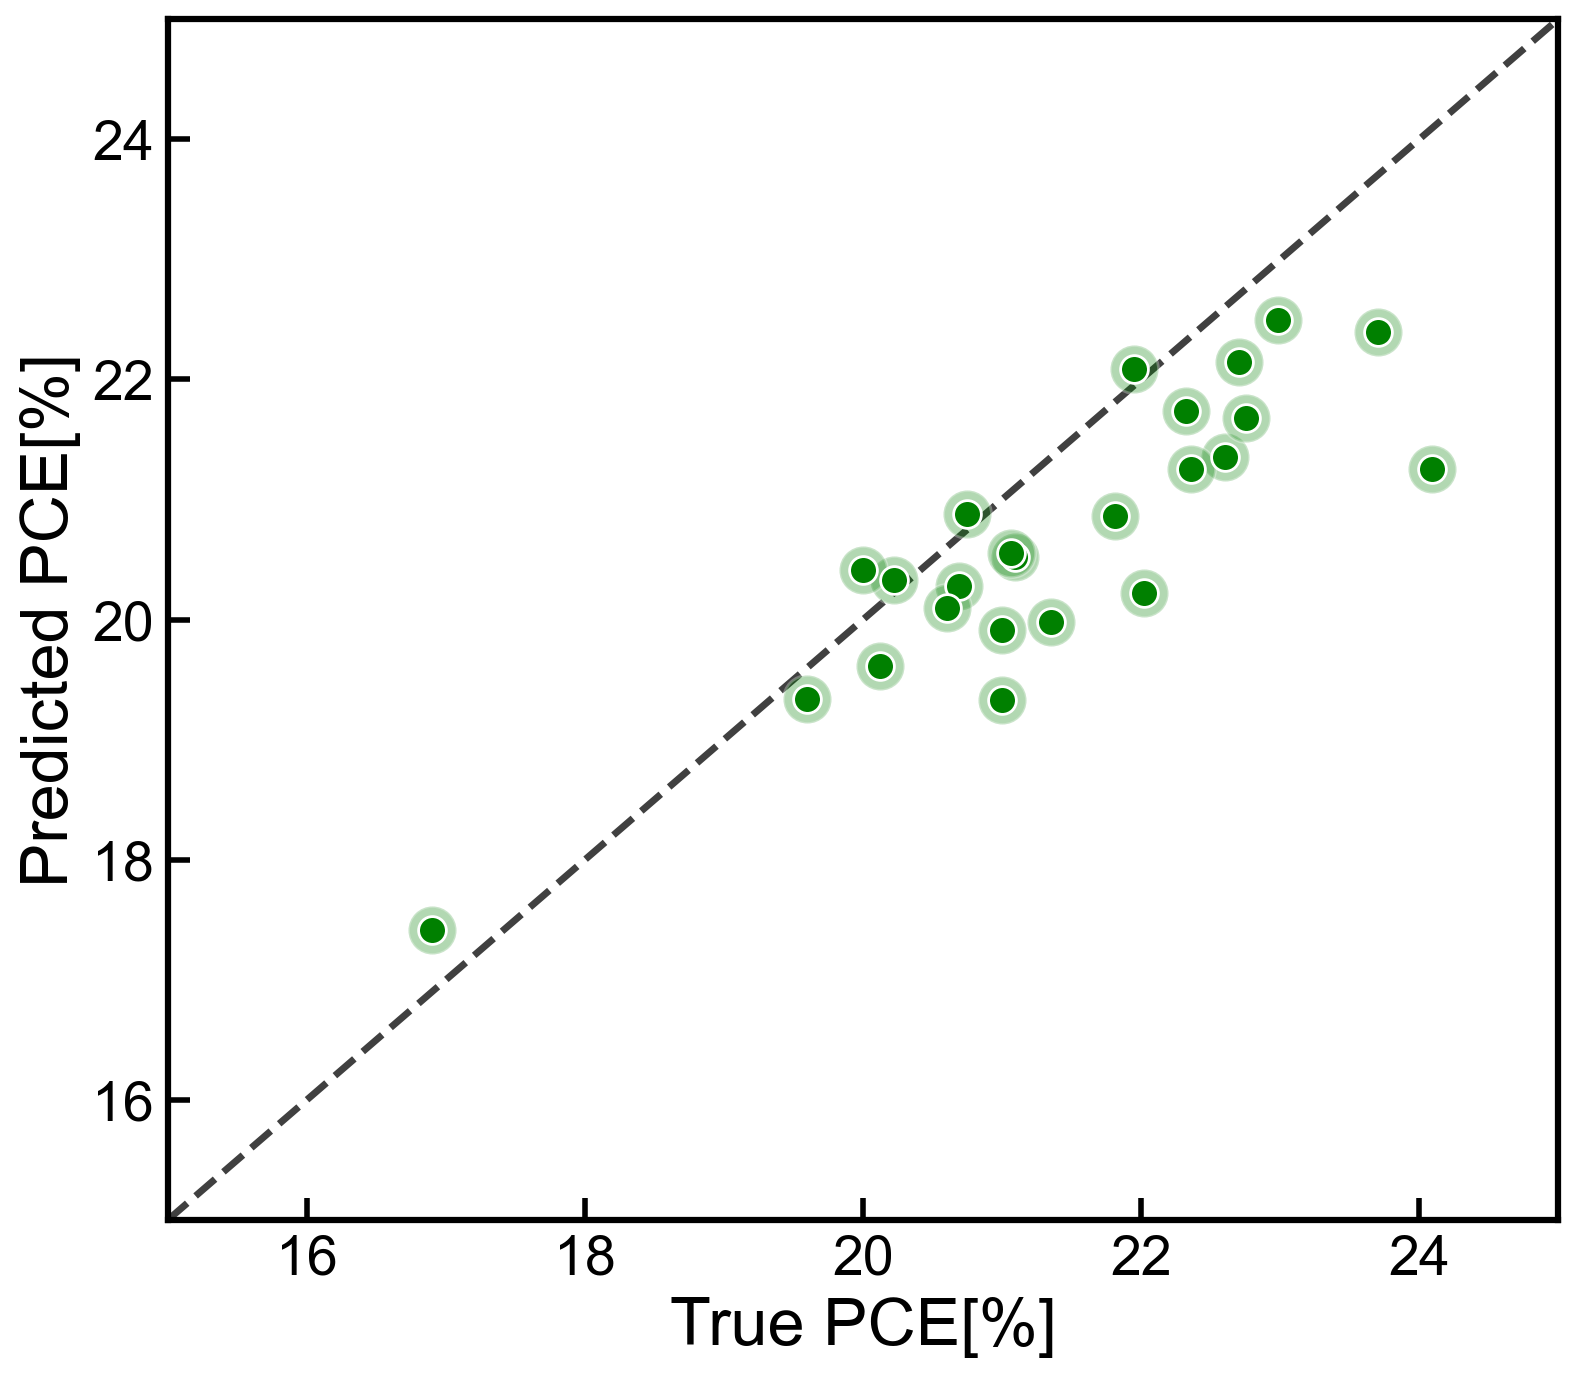

In [9]:
#Plt True vs Pred
def prediction_vs_ground_truth_fig(y_train, y_train_hat):
    from sklearn import metrics
    fontsize = 20
    lims = (15, 25)
    plt.figure(figsize=(8,7))
    plt.style.use('default')
    plt.rc('xtick', labelsize=fontsize)
    plt.rc('ytick', labelsize=fontsize)
    plt.rcParams['font.family']="Arial"
    plt.scatter(y_train, y_train_hat, s=300, color='green',alpha=0.3, edgecolor='w') 
    plt.scatter(y_train, y_train_hat, s=100,c='green',edgecolors='w')
    plt.plot(lims, lims, 'k--', alpha=0.75, linewidth =2.5,zorder=0)
    plt.xlabel('True PCE[%]', fontsize=24)
    plt.ylabel('Predicted PCE[%]', fontsize=24)
    plt.tick_params(direction='in',length=8, width=2, labelsize = 20,pad=5)
    plt.xlim([15,25]) 
    plt.ylim([15,25])
    plt.rcParams['font.family']="Arial"

    ax = plt.gca()
    for spine in ax.spines.values():
        spine.set_linewidth(2.25) 
    plt.tight_layout()
    plt.show()

prediction_vs_ground_truth_fig(y_true, y_pred)